In [83]:
%load_ext autoreload 

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from easydict import EasyDict as edict
import yaml
import pandas as pd
import os

from scipy.signal import convolve2d, convolve
from scipy.signal.windows import blackman, gaussian
from scipy import stats 

import copy
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.cluster import MeanShift
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_swiss_roll,\
                             make_s_curve,\
                             make_moons, \
                             make_blobs

from collections import defaultdict
from joblib import Parallel, delayed
from umap import UMAP

from IPython.core.debugger import set_trace
from IPython.display import clear_output

import torch
from torch import nn
from torch import optim

from train_utils import bruteforce_projection, oja_rule, hebb_rule, GHA_rule, criterion_rule, check_nan
from metric_utils import calculate_Q_metrics, \
                         strain, \
                         to_numpy, \
                         cosine_sim, \
                         variance, \
                         get_k_th_moment   
                         
from input_utils import DataGenerator, \
                        make_random_affine, \
                        make_bicluster, \
                        make_kurtosis_first_direction, \
                        make_skewness_first_direction

from models_utils import init_weights, universal_approximator, dJ_criterion

from joblib import Parallel, delayed

plt.rcParams['font.size'] = 20
device = torch.device('cuda:0')
%autoreload 2

def absolute(fun):
    def wrapper(X):
        return np.abs(fun(X))
    return wrapper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
# from MulticoreTSNE import MulticoreTSNE
# tsne = MulticoreTSNE()


# Criterion

In [ ]:
# SCALER = StandardScaler() 
# corr_thresh = 0.1
# angle = np.random.random_sample()*2*np.pi 
# distance = 0.5 + np.random.random_sample()
# corr = corr_thresh + min(0.99-corr_thresh, np.random.random_sample())

# input_parameters = {'generator': make_kurtosis_bicluster, #make_s_curve, 
#                     'generator_kwargs': {'n_samples':1000, 
#                                          'distance':distance, 
#                                          'angle':angle,
#                                          'corr':corr}, # 1e-1
#                     'normalize':True,
#                     'unsupervised':False,
#                     'scaler':SCALER,
#                     'whiten':True
#                    }

# inpt, outpt = create_data(**input_parameters)
# inpt_tensor = torch.tensor(inpt,dtype=torch.float32)

In [157]:
SCALER = StandardScaler() 
input_parameters = {'generator': make_kurtosis_first_direction, #make_s_curve, 
                    'generator_kwargs': {'n_samples':1000, 
                                         'ktype':'neg',
                                         'offset':4,
                                         'replace_ratio':0.25}, # 1e-1
                    'unsupervised':False,
                    'scaler':SCALER,
                    'whiten':True
                   }


create_data = DataGenerator(**input_parameters)

inpt, outpt, _ = create_data()
inpt_tensor = torch.tensor(inpt,dtype=torch.float32)

In [158]:
# SCALER = StandardScaler() 
# input_parameters = {'generator': make_skewness_first_direction, #make_s_curve, 
#                     'generator_kwargs': {'n_samples':1000, 
#                                          'stype':'pos',
#                                          'k':2}, # 1e-1
#                     'unsupervised':False,
#                     'scaler':SCALER,
#                     'whiten':True
#                    }

# create_data = DataGenerator(**input_parameters)


# inpt, outpt, _ = create_data(**input_parameters)
# inpt_tensor = torch.tensor(inpt,dtype=torch.float32)

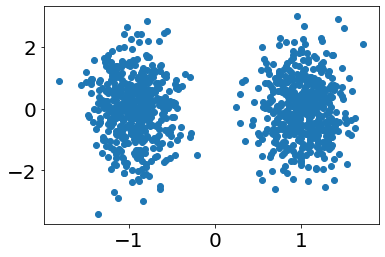

In [159]:
plt.scatter(inpt_tensor[0], inpt_tensor[1])

In [160]:
# check whitening
(inpt@inpt.T / inpt.shape[1]).round(2)

array([[ 1.  , -0.01],
       [-0.01,  1.  ]])

In [163]:
k = 4
σ = 1
μ = 0

arr_mult = 5

criterion = get_k_th_moment(k, σ=σ, μ=μ)
f = lambda y: k*(y**(k-1))
# f = lambda y: k*(torch.sign(y)*(y**(k-1)))

# criterion = variance
# f = lambda y: 2*y

dJ = dJ_criterion([criterion])
y = torch.randn(1,1000)
(dJ(y) == f(y)).all()

tensor(True)

In [164]:
#stats.skew, #stats.kurtosis, #criterion,
crit_map, W_grid = bruteforce_projection(n_grid_samples=100,
                                         criterion=absolute(criterion), 
#                                          criterion=criterion, 
                                         X=inpt,
                                         w_min=-1,
                                         w_max=1)

crit_thr = np.percentile(crit_map.flatten(), 99.)
mask = crit_map > crit_thr
assert mask.sum() > 0

W_s_bf = W_grid[mask]

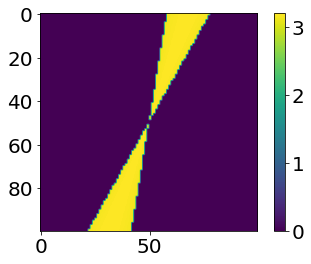

In [165]:
crit_map_bin = crit_map.copy()
crit_map_bin[crit_map_bin < np.percentile(crit_map.flatten(), 90.)] = 0
# crit_map_bin[crit_map_bin >= crit_thr] = 1

plt.imshow(np.rot90(crit_map_bin))
plt.colorbar()

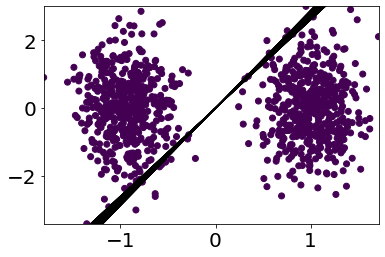

In [166]:
plt.scatter(inpt[0], inpt[1], c=outpt[0])

for w_bf in W_s_bf:
    plt.arrow(0,0,w_bf[0]*arr_mult, w_bf[1]*arr_mult, color='black')
plt.xlim(inpt[0].min(), inpt[0].max())
plt.ylim(inpt[1].min(), inpt[1].max())
plt.show()


In [167]:
# W = torch.randn(1,2,dtype=torch.float32)
# W /= W.norm()
# y = W@inpt_tensor

In [168]:
# plt.hist(x, alpha=0.5, label=criterion(x))
# plt.hist(y, alpha=0.5, label=criterion(y))
# plt.legend()
# plt.show()

In [172]:
learning_rule = criterion_rule #hebb_rule #criterion_rule

n_trials = 20
max_epochs = 1000
lr = 1e-3

T = inpt.shape[1]
dt = 1 # T//4

crit_rtol = 1e-1*crit_thr # abs tolerance for early stopping

############
# learning #
############
def train(inpt_tensor, max_plateu_epochs=50, normalize_W=False):
    
    # initialize
    W = torch.randn(1,2)
    W /= torch.norm(W)
    results = defaultdict(list)
    
    for epoch in range(max_epochs):
        for t in list(range(0,T,dt)):

            inp = inpt_tensor[:,t:t+dt]
            out = f(W@inp)
            
            lr = min(5e-4, 2./inp.norm())
            dW = learning_rule(inp, out, W)
            W = W + lr*dW
            
            # stuff for stability
            if torch.isnan(W).any():
                raise RuntimeError()
            if normalize_W:
                W /= torch.norm(W)

        # calculate criterion
        W_n = to_numpy(W).copy()
        W_n /= np.linalg.norm(W_n)
        out_all = W_n@inpt
        J = absolute(criterion)(out_all)
        
        results['Js'].append(J)
        results['W_n_s'].append(W_n)
        
        # exit conditions 
        if epoch > max_plateu_epochs:
            W_n_s_std = np.concatenate(results['W_n_s'][-max_plateu_epochs:]).std(0)
            if W_n_s_std.max() < 1e-1:
                break

        if J >= crit_thr:
            break
    
    return results
    
    
results = Parallel(n_jobs=-1)(delayed(train)(inpt_tensor) 
                    for _ in tqdm(range(n_trials)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 103.61it/s]


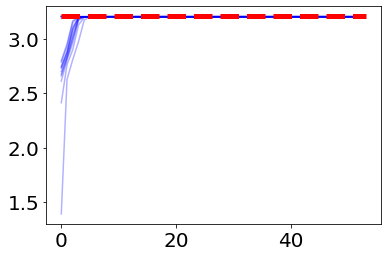

In [173]:
maxlen = 0 
for results_sample in results:
    Js = results_sample['Js']
    # length of threshold line
    maxlen = len(Js) if len(Js)>maxlen else maxlen 
    plt.plot(np.arange(max_epochs)[:len(Js)], Js, color='blue', alpha=0.3)
    
plt.hlines(crit_thr, 0,
           maxlen,
           linestyle='--', color='red', linewidth=5)

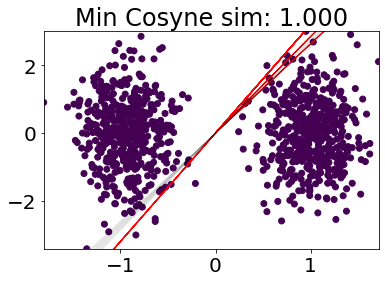

In [174]:
plt.scatter(inpt[0], inpt[1], c=outpt[0])

sims_all = []
for results_sample in results:
    W = results_sample['W_n_s'][-1]
    plt.arrow(0,0,W[0,0]*arr_mult,W[0,1]*arr_mult, color='red')    

    sims = []
    for w_bf in W_s_bf:
        sims.append(np.abs(cosine_sim(w_bf, W[0])))
    sims_all.append(max(sims))

for w_bf in W_s_bf:
    plt.arrow(0,0,w_bf[0]*arr_mult, w_bf[1]*arr_mult, color='black', alpha=0.01)

plt.xlim(inpt[0].min(), inpt[0].max())
plt.ylim(inpt[1].min(), inpt[1].max())
plt.title('Min Cosyne sim: {:.3f}'.format(min(sims_all)))
plt.show()

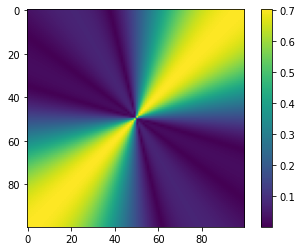

In [69]:
plt.imshow(np.rot90(crit_map))
plt.colorbar()

In [49]:
# plt.plot(Js)
# plt.hlines(crit_thr, 0, len(Js), linestyle='--', color='red')

In [ ]:
# dataset_iter = np.linspace(-np.pi, np.pi, 100)

In [ ]:
# results = {}

# failed_examples = defaultdict(list)

# for angle in tqdm(dataset_iter):
    
#     results_angle = defaultdict(list)
    
#     # create tensors
#     input_parameters['generator_kwargs']['angle'] = angle
#     inpt, outp = create_data(**input_parameters)
#     inpt_torch = torch.tensor(inpt, dtype=torch.float).to(device)
#     outp_torch = torch.tensor(inpt, dtype=torch.float).to(device)
    
#     #############
#     # create GT #
#     #############
#     crit_map, W_grid = bruteforce_projection(n_grid_samples=100,
#                                              criterion=criterion,
#                                              X=inpt,
#                                              w_min=-1.5,
#                                              w_max=1.5)

#     crit_thr = np.percentile(crit_map.flatten(), 99.)
#     mask = crit_map > crit_thr
#     assert mask.sum() > 0
    
# #     ms = MeanShift()
# #     y_ = ms.fit_predict(W_grid[mask])
# #     W_s_bf = ms.cluster_centers_

#     W_s_bf = W_grid[mask]
    
#     ############
#     # learning #
#     ############
#     for _ in range(n_trials):
        
#         # start of the trial
#         #################################
#         Js = []
    
#         # initialize
#         W = np.random.randn(1,2)
#         W /= np.linalg.norm(W)

#         W_s = []
#         I = np.eye(2)

#         for epoch in range(max_epochs):
#             for t in list(range(0,T,dt)):
#                 inp = inpt[:,t:t+dt]
#                 out = f(W@inp)
                
#                 W_s.append(W)
#                 dW = learning_rule(inp, out, W)
#                 W = W + lr*dW

#             # calculate criterion
#             W_n = W.copy()
#             W_n /= np.linalg.norm(W_n)
#             out_all = W_n@inpt

#             J = criterion(out_all)
#             Js.append(J)
            
#             if J >= crit_thr - crit_atol:
#                 break
#         #########################################
        
#         # didn't converge
#         if epoch == max_epochs-1:
#             failed_example = {'inpt':inpt,
#                               'W_init':W_init,
#                               'W_s':W_s,
#                               'J_s':Js}
#             failed_examples[angle].append(failed_example)
        
#         W_s = np.array(W_s)
        
#         results_angle['J_s'].append(Js)
#         results_angle['J_s_ref'].append(crit_thr)
#         results_angle['W_s'].append(W_s)
        
#         sims  = []

#         for w_bf in W_s_bf:
#             sims.append(cosine_sim(w_bf, W[0]))
            
#         results_angle['cos_sim'].append(max(sims))
        
#     results[angle] = results_angle


In [ ]:
get_last = lambda x: [x_[-1] for x_ in x]
J_s_ref_all = np.array([results[angle]['J_s_ref'] for angle in dataset_iter])
J_s_all = np.array([get_last(results[angle]['J_s']) for angle in dataset_iter])
J_diff = J_s_ref_all - J_s_all

In [ ]:
plt.hist(J_diff.flatten(), bins=50)
plt.show()

In [213]:
cos_sim_all = np.array([results[angle]['cos_sim'] for angle in dataset_iter])

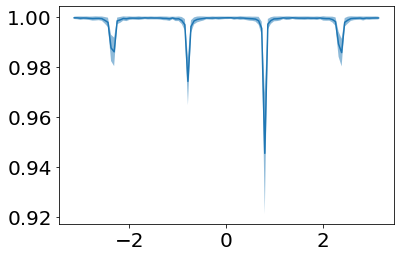

In [231]:
cos_sim_all_mean = cos_sim_all.mean(1)
cos_sim_all_std = cos_sim_all.std(1)

plt.plot(dataset_iter, cos_sim_all_mean)
plt.fill_between(dataset_iter, cos_sim_all_mean-cos_sim_all_std,
                                 cos_sim_all_mean+cos_sim_all_std, alpha=0.5)

# plt.ylim(cos_sim_all.min(), cos_sim_all.max())
plt.show()

# Batch-wise Hebbian plasticity